In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline

In [2]:
# function for reading the data files
def build_data_frame(path):
    rows = []
    index = []
    classification =[]
    for file_name, text, classification in read_files(path):
        rows.append({'text':text, 'class': classification})
        index.append(file_name)
        
    data_frame = pd.DataFrame(rows,index=index)
    return data_frame

In [3]:
def read_files(path):
    newline=''
    for root, dir_names, file_names in os.walk(path):
        print('Root folder: {0}'.format(root))
        print('Number of files read: {0}'.format(len(file_names)))
        for file_name in file_names:
            file_path = os.path.join(root,file_name)
            if(os.path.isfile(file_path)):
                #print(file_name)
                if("D" in file_name):
                    label="D"
                elif("R" in file_name):
                    label="R"
                else:
                    label="X"
                lines = []
                f = open(file_path)
                for line in f:
                    lines.append(line.rstrip("\n"))
                f.close()
                content=newline.join(lines)
                yield file_name, content, label

In [4]:
# here I set the path of data set using os.getcwd()
path = os.path.join(os.getcwd(), 'data_set')
# intitalize the empty data frame
data = pd.DataFrame({'text':[],'class':[]})
# call the function to build the data set
data=data.append(build_data_frame(path))

Root folder: /home/pk-user/Documents/IE594-Data-Science/Speech-classification/data_set
Number of files read: 856


In [5]:
#Parse file name, reorder columns and print to csv

file_name = pd.Series(data.index.values)
bill, speaker, meta_date, file_name= file_name.str.split('_').str
data['bill_id'] = bill.values
data['speaker_id'] = speaker.values
data['meta_date'] = meta_date.values
data = data[['meta_date', 'speaker_id', 'class', 'bill_id', 'text']]
data.to_csv('clean_data.csv')

#Split data validation / test - crappy way of doing it by assigning the train data do 'data'

data, data_test = train_test_split(data, test_size = 0.2, stratify = data['class'], random_state = 42)

### Pipeline for executing the task

In [6]:
# Using Pipeline 
# Define scorers

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

f1_R = make_scorer(f1_score,pos_label='R')
f1_D = make_scorer(f1_score,pos_label='D')
f1_macro = make_scorer(f1_score, average = 'macro')

### Pipeline with GridSearchCV with varying ngram_range and varying alpha

In [7]:
param_grid = dict(classifier__alpha=[20,10,5,1, 0.5, 0.005,0.0005],vectorizer__ngram_range=[(1,3),(1,4),(2,3),(2,4)])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring=f1_macro, cv=5)
grid_search.fit(data['text'], data['class'])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'classifier__alpha': 0.005, 'vectorizer__ngram_range': (1, 4)}
0.739500671196


In [8]:
#Create N-gram features
count_vectorizer = CountVectorizer(ngram_range=(1, 4))
x_train = count_vectorizer.fit_transform(data['text'])
y_train = data['class']
x_test = count_vectorizer.transform(data_test['text'])
y_test = data_test['class']


In [19]:
results = []

In [22]:
#Naive Bayes classifier
classifier = MultinomialNB(alpha = 0.005)
classifier.fit(x_train, y_train)


print(classifier.coef_)

predictions = classifier.predict(x_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

results.append(('MN-NB',f1_score(y_test, predictions, average = 'macro')))

[[ -8.6201883  -13.1038933  -18.40719821 ..., -13.1038933  -13.1038933
  -13.1038933 ]]
[[53 25]
 [14 80]]
             precision    recall  f1-score   support

          D       0.79      0.68      0.73        78
          R       0.76      0.85      0.80        94

avg / total       0.78      0.77      0.77       172



In [24]:
#SVM Classifier
classifier_svc = LinearSVC()
classifier_svc.fit(x_train, y_train)
predictions_svc = classifier_svc.predict(x_test)
rep = classification_report(y_test, predictions_svc)
print(rep)
results.append(('SVM',f1_score(y_test, predictions_svc, average = 'macro')))
print('f1 scores: {}'.format(results))

             precision    recall  f1-score   support

          D       0.61      0.51      0.56        78
          R       0.64      0.72      0.68        94

avg / total       0.63      0.63      0.62       172

f1 scores: [('MN-NB', 0.76752729163056665), ('SVM', 0.61777777777777776)]


In [25]:
#Random Forest Classifier
classifier_rf = RandomForestClassifier(n_estimators=30,max_features="sqrt",random_state=1)
classifier_rf.fit(x_train, y_train)
predictions_rf = classifier_rf.predict(x_test)
print(classification_report(y_test, predictions_rf))
results.append(('Random Forest', f1_score(y_test, predictions_rf, average = 'macro')))
print('f1 scores: {}'.format(results))

             precision    recall  f1-score   support

          D       0.73      0.46      0.57        78
          R       0.66      0.86      0.75        94

avg / total       0.69      0.68      0.67       172

f1 scores: [('MN-NB', 0.76752729163056665), ('SVM', 0.61777777777777776), ('Random Forest', 0.65673645633005551)]


In [27]:
results.append(('Adaboost-Trees', 0.70))

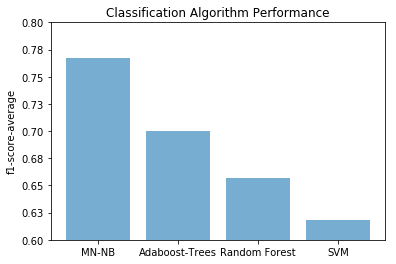

In [98]:
results = sorted(results, key=lambda tup: tup[1],reverse=True)
labels, scores = zip(*results)
y_pos = np.arange(len(labels))

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

plt.bar(y_pos, scores, align = 'center', alpha=0.6)
plt.xticks(y_pos, labels)
plt.ylabel('f1-score-average')
plt.title('Classification Algorithm Performance')
plt.ylim(0.6,0.8)
plt.show()

In [77]:
# from sklearn.decomposition import SparsePCA
# pca = SparsePCA(n_components=2)
# proj = pca.fit_transform(x_test.toarray())
# plt.scatter(proj[:, 0], proj[:, 1], c=y_test) 

# plt.colorbar() 

In [13]:
# classifier_rf = RandomForestClassifier(max_features="sqrt")
# estimators=list(np.arange(10,500,10))
# scores=[]
# scoreoptimal=0
# noptimal=10
# for estimator in estimators:
#     classifier_rf = RandomForestClassifier(n_estimators=estimator,max_features="sqrt")
#     classifier_rf.fit(x_train, y_train)
#     predictions_rf = classifier_rf.predict(x_test)
#     score=np.round((f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="R")
#                     +f1_score(y_test,predictions_rf,labels=["R","D"],pos_label="D"))/2,decimals=2)
#     scores.append(score)
#     if(score>scoreoptimal):
#         noptimal=estimator
#         scoreoptimal=score

In [14]:
# import matplotlib.pyplot as plt
# plt.plot(estimators,scores)
# plt.scatter(noptimal,scoreoptimal,c="red",s=50)
# plt.title("No of trees in model vs F1 Score")
# plt.xlabel("No of trees")
# plt.ylabel("F1 Score")
# plt.show()
# scoreoptimal
# noptimal